# CZĘŚĆ 1 - OPTYMALIZACJA

## OPIS ZESTAWU DANYCH
Dane składają się z informacji o przylotach i odlotach wszystkich lotów komercyjnych w USA od października 1987 do kwietnia 2008 – przede wszystkim o ich opóźnieniach. Zbiór danych jest bardzo duży (120mln rekordów, 12GB danych) – na potrzeby projektu wykorzystamy jedynie dane z lat 2006-2008 (to ograniczy ich rozmiar do ok. 1.5GB).

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from matplotlib.pyplot import figure
from matplotlib import pyplot as plt
import statistics
from sklearn.impute import KNNImputer
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnull, when, count, col, hour, mean, lit, stddev,abs

#### OPIS KLAS
W sumie klas jest 29, opisują one następujące informacje:
Rok, miesiąc, dzień miesiąca, dzień tygodnia, rzeczywisty czas odlotu, zaplanowany czas odlotu, rzeczywisty czas przylotu, zaplanowany czas przylotu, kod przewoźnika, numer lotu, numer ogonowy samolotu, całkowity czas lotu w minutach, rzeczywisty czas lotu, całkowity czas w powietrzu, opóźnienie lotu w minutach, miejsce startu, miejsce docelowe, odległość w milach, dane dotyczące przyjazdu taksówki, informacje o tym czy lot był anulowany, powód anulowania (pogoda, przewoźnik, ochron, NAS), przekierowanie (tak/nie), opóźnienie przewoźnika w minutach, opóźnienie pogodowe w minutach, opóźnienie NAS w minutach, opóźnienie z powodów bezpieczeństwa w minutach, sumaryczne opóźnienie w minutach.

In [2]:
data = pd.read_csv('./data/2007.xls', delimiter=',')
data.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2007,1,1,1,1232.0,1225,1341.0,1340,WN,2891,...,4.0,11.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0
1,2007,1,1,1,1918.0,1905,2043.0,2035,WN,462,...,5.0,6.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0
2,2007,1,1,1,2206.0,2130,2334.0,2300,WN,1229,...,6.0,9.0,0.0,NaN,0.0,3.0,0.0,0.0,0.0,31.0
3,2007,1,1,1,1230.0,1200,1356.0,1330,WN,1355,...,3.0,8.0,0.0,NaN,0.0,23.0,0.0,0.0,0.0,3.0
4,2007,1,1,1,831.0,830,957.0,1000,WN,2278,...,3.0,9.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0


Jak widać w powyższej tabeli, niektóre kolumny zawierają dane tekstowe - UniqueCarrier, TailNum, Origin, Dest i CancellationCode.
Z racji tego, że w projekcie chcielibyśmy się skupić na powiązaniach między opóźnieniami/odwołaniami lotów, a momentem ich odbywania, część danych będzie nam zbędna. Dlatego też zdecydowaliśmy się na usuięcie kolumn:
- UniqueCarrier - indywidualny kod przewoźnika
- TailNum - numer ogonowy
- Origin - miejsce rozpoczęcia podróży
- Dest - cel podróży
- CancellationCode - kod odwołania

In [3]:
data.drop('UniqueCarrier', inplace=True, axis =1)
data.drop('TailNum', inplace=True, axis =1)
data.drop('Origin', inplace=True, axis =1)
data.drop('Dest', inplace=True, axis =1)
data.drop('CancellationCode', inplace=True, axis =1)

In [4]:
data.describe()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,FlightNum,ActualElapsedTime,...,Distance,TaxiIn,TaxiOut,Cancelled,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
count,3593413.0,3.593413e+06,3.593413e+06,3.593413e+06,3.502301e+06,3.593413e+06,3.494258e+06,3.593413e+06,3.593413e+06,3.494258e+06,...,3.593412e+06,3.593412e+06,3.593412e+06,3.593412e+06,3.593412e+06,3.593412e+06,3.593412e+06,3.593412e+06,3.593412e+06,3.593412e+06
mean,2007.0,3.454024e+00,1.564337e+01,3.918267e+00,1.340944e+03,1.331584e+03,1.484115e+03,1.496190e+03,2.237950e+03,1.249881e+02,...,7.081792e+02,6.554661e+00,1.600806e+01,2.535529e-02,2.238263e-03,3.864038e+00,8.129967e-01,3.736539e+00,2.299653e-02,5.139931e+00
std,0.0,1.679768e+00,8.734800e+00,1.980029e+00,4.787119e+02,4.639604e+02,5.055874e+02,4.803858e+02,1.988754e+03,7.028618e+01,...,5.536289e+02,5.165002e+00,1.168459e+01,1.572018e-01,4.725731e-02,2.058578e+01,1.001654e+01,1.587624e+01,1.036474e+00,2.140643e+01
min,2007.0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.200000e+01,...,1.100000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2007.0,2.000000e+00,8.000000e+00,2.000000e+00,9.300000e+02,9.300000e+02,1.108000e+03,1.115000e+03,6.170000e+02,7.500000e+01,...,3.140000e+02,4.000000e+00,1.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2007.0,3.000000e+00,1.600000e+01,4.000000e+00,1.330000e+03,1.325000e+03,1.514000e+03,1.519000e+03,1.550000e+03,1.070000e+02,...,5.520000e+02,5.000000e+00,1.300000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,2007.0,5.000000e+00,2.300000e+01,6.000000e+00,1.734000e+03,1.720000e+03,1.912000e+03,1.907000e+03,3.685000e+03,1.550000e+02,...,9.360000e+02,8.000000e+00,1.900000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,2007.0,6.000000e+00,3.100000e+01,7.000000e+00,2.400000e+03,2.359000e+03,2.400000e+03,2.400000e+03,9.600000e+03,1.270000e+03,...,4.962000e+03,5.450000e+02,4.350000e+02,1.000000e+00,1.000000e+00,1.409000e+03,1.137000e+03,1.352000e+03,3.820000e+02,1.014000e+03


#### TO DO: dodać komentarz dotyczący średnich

## WIZUALIZACJA DANYCH

### BOXPLOTY

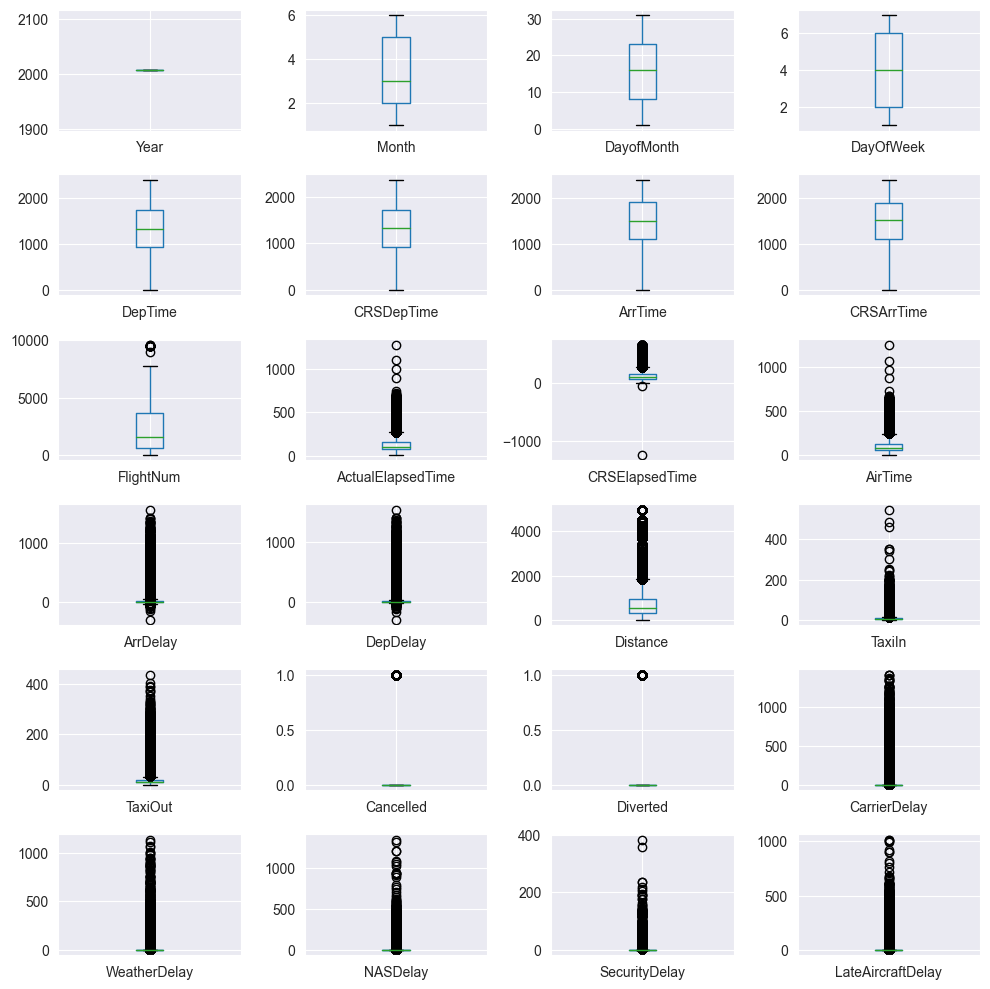

In [5]:
fig, axes = plt.subplots(6,4, figsize=(10,10))
for c, i in zip(data.columns, range(0,24)):
    a = data.boxplot(column=c, ax=axes.flatten()[i])
plt.tight_layout()
plt.show()

#### TO DO: Dodać komentarz dotyczący boxplotów

### HISTOGRAMY

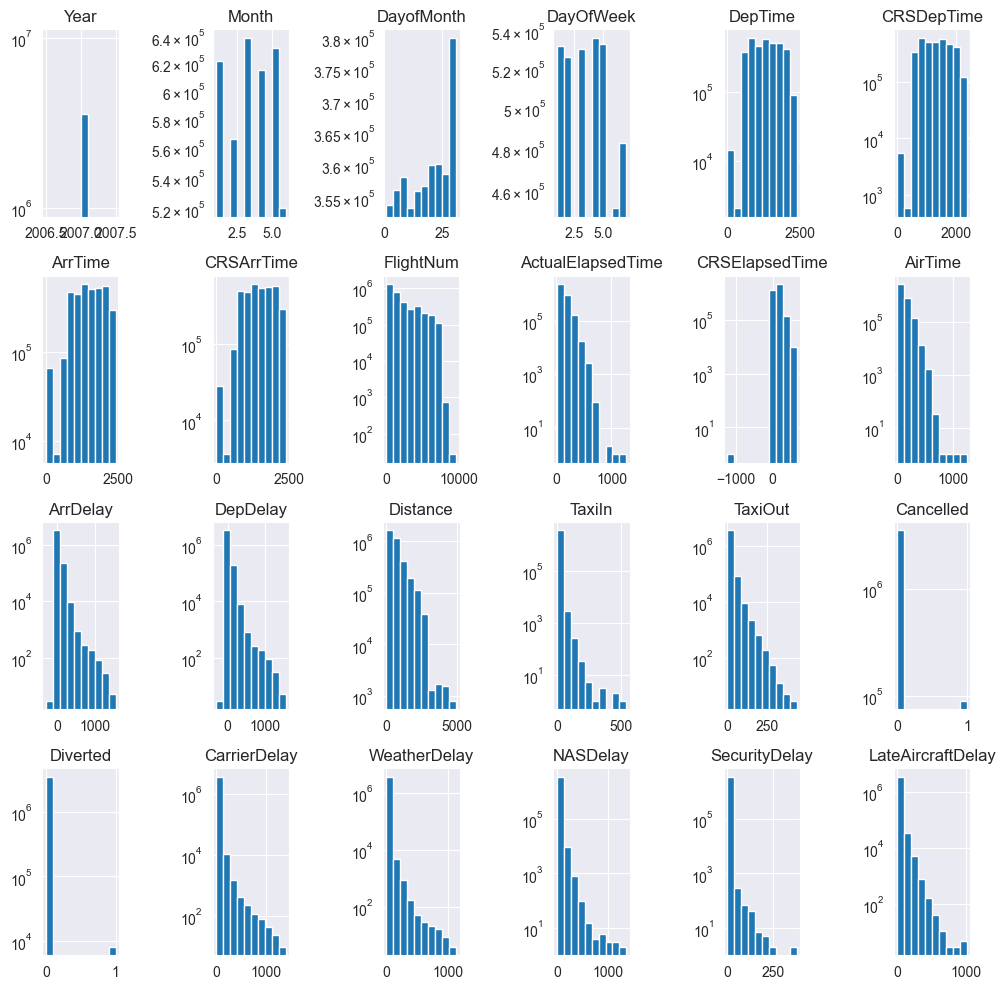

In [6]:
fig, axes = plt.subplots(4, 6, figsize=(10,10))
for c, i in zip(data.columns, range(0,24)):
    a = data.hist(column=c, ax=axes.flatten()[i], log= True)
plt.tight_layout()
plt.show()

#### TO DO: Dodać komentarz dotyczący histogramów

### SCATTER PLOT

In [7]:
# plt.scatter(range(len(data)), data)
# TO DO: Dodać scatter plot

#### TO DO: Dodać komentarz dotyczący scatterplot

## PROBLEMY Z DANYMI - DANE BRAKUJĄCE, NIEPRAWIDŁOWE, ODSTAJĄCE

### SPRAWDZENIE POPRAWNOŚCI TYPÓW DANYCH

In [8]:
import pyarrow as pa

table = pa.Table.from_pandas(data)
print(table.schema)

Year: int64
Month: int64
DayofMonth: int64
DayOfWeek: int64
DepTime: double
CRSDepTime: int64
ArrTime: double
CRSArrTime: int64
FlightNum: int64
ActualElapsedTime: double
CRSElapsedTime: double
AirTime: double
ArrDelay: double
DepDelay: double
Distance: double
TaxiIn: double
TaxiOut: double
Cancelled: double
Diverted: double
CarrierDelay: double
WeatherDelay: double
NASDelay: double
SecurityDelay: double
LateAircraftDelay: double
-- schema metadata --
pandas: '{"index_columns": [{"kind": "range", "name": null, "start": 0, "' + 3110


#### TO DO: Dodać komentarz dotyczący danych w złym formacie

### NAPRAWA WIERSZY Z PUSTYMI DANYMI

In [14]:
# Obliczenie ilosci pustych danych
np.sum(data.isna())

Year                 0
Month                0
DayofMonth           0
DayOfWeek            0
DepTime              0
CRSDepTime           0
ArrTime              0
CRSArrTime           0
FlightNum            0
ActualElapsedTime    0
CRSElapsedTime       0
AirTime              0
ArrDelay             0
DepDelay             0
Distance             0
TaxiIn               0
TaxiOut              0
Cancelled            0
Diverted             0
CarrierDelay         0
WeatherDelay         0
NASDelay             0
SecurityDelay        0
LateAircraftDelay    0
dtype: int64

In [15]:
sizeBeforeDeleteNull= data.count()
dataWithoutNull = data.dropna()
sizeAfterDeleteNull =  dataWithoutNull.count()
print("Usunieto: ", sizeBeforeDeleteNull - sizeAfterDeleteNull)

print("Percent od reduced rows: ", 100*sum(sizeBeforeDeleteNull - sizeAfterDeleteNull)/sum(sizeBeforeDeleteNull))

Usunieto:  Year                 0
Month                0
DayofMonth           0
DayOfWeek            0
DepTime              0
CRSDepTime           0
ArrTime              0
CRSArrTime           0
FlightNum            0
ActualElapsedTime    0
CRSElapsedTime       0
AirTime              0
ArrDelay             0
DepDelay             0
Distance             0
TaxiIn               0
TaxiOut              0
Cancelled            0
Diverted             0
CarrierDelay         0
WeatherDelay         0
NASDelay             0
SecurityDelay        0
LateAircraftDelay    0
dtype: int64
Percent od reduced rows:  0.0


In [ ]:
### TO DO: ZMIENIC SPOSÓB RADZENIA SOBIE Z PUSTYMI DANYMI
### TO DO: Dodać komentarz dotyczący danych pustych

### USUWANIE DANYCH ODSTAJĄCYCH

In [12]:
sizeBefore = np.shape(data)[0]
for col in data.columns:
    data = data[np.abs(data[col]-data[col].mean()) <= (3*data[col].std())]
sizeAfter =  np.shape(data)[0]
print("Count of reduced rows: ", sizeBefore - sizeAfter)
print("Percent od reduced rows: ", 100*(sizeBefore - sizeAfter)/sizeBefore)

Count of reduced rows:  53612
Percent od reduced rows:  0.024441983570092442


#### TO DO: Dodać komentarz dotyczący danych odstających

# KORELACJE

In [ ]:
sns.pairplot(data)

In [ ]:
plt.figure(figsize=(20, 20), dpi=80)
corrMatrix = data.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

#### TO DO: Dodać komentarz dotyczący korelacji między danymi, ew dodać pairploty do wybranych danych

In [ ]:
### TO DO: "Normalizacja danych (przedstawić wyniki min-max i standaryzacji). Zastanowić się nad zakresem skalowania danych"


# REDUKCJA WYMIAROWOŚCI

In [ ]:
### TO DO: Genetyczna optymalizacja cech

In [ ]:
# Genetyczna optymalizacja cech - NA RAZIE SAMA SELEKCJA NA PODSTAWIE KORELACJI
pandasDF = data.filter(["DayOfWeek", "DayofMonth", "Distance", "DepTime", "Cancelled", "Diverted", "LateAircraftDelay", "DepDelay", "ArrDelay"], axis = 1)

In [ ]:
spark = SparkSession.builder.master("local").appName("Project").getOrCreate()
sparkDF=spark.createDataFrame(pandasDF)
sparkDF.printSchema()
sparkDF.show()

In [ ]:
#wybor algorytmu uczenia maszynowego- min 3 modele i wybrac najlepszy

In [ ]:
#przetestowanie zespolu klasyfikatorow pjedyncznych i porownanie wynikow

In [ ]:
#wybranie odpowiedniej metryki wraz z komentarzem, dkonanie testow innych metryk, przedstawienie wynikow (czulosc, precyzja, f1, accuracy, macierz pmylek), reczna walidacja krzyzowa  testwanie na niej wszytkich miar

In [ ]:
# optymalizacja parametrow klasyfikatorow

In [ ]:
# wyniki